In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
taxies = '/content/drive/MyDrive/DataMining/AnomalyDetection/nyc_taxi.csv'

In [4]:
df = pd.read_csv(taxies)
print(df.head())

             timestamp  value
0  2014-07-01 00:00:00  10844
1  2014-07-01 00:30:00   8127
2  2014-07-01 01:00:00   6210
3  2014-07-01 01:30:00   4656
4  2014-07-01 02:00:00   3820


In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp'] = df['timestamp'].dt.date
grouped_df = df.groupby('timestamp')['value'].sum().reset_index()
print(df.head())

    timestamp  value
0  2014-07-01  10844
1  2014-07-01   8127
2  2014-07-01   6210
3  2014-07-01   4656
4  2014-07-01   3820


Grouped each value under the same date so we can plot a graph that can be read.

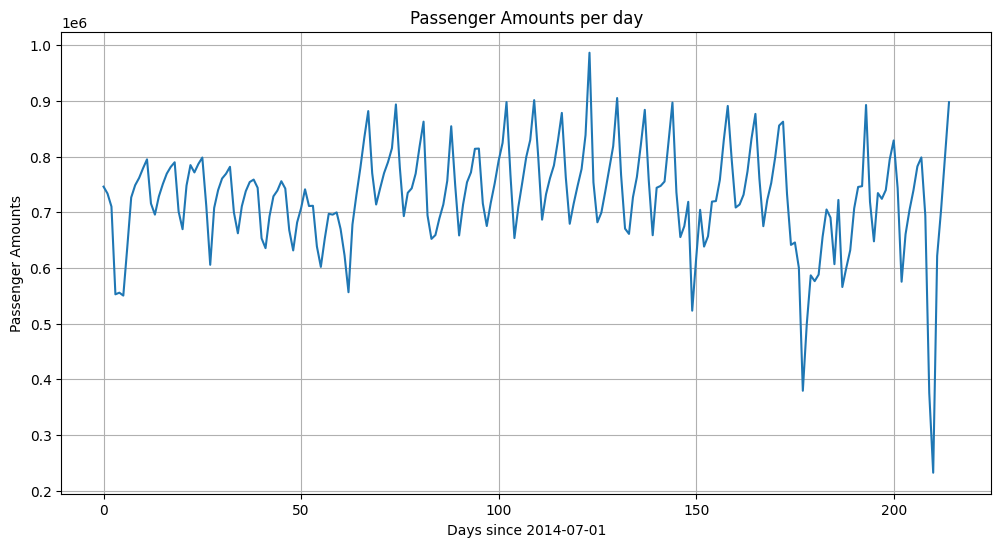

In [6]:
# Plot the grouped data
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(grouped_df.index, grouped_df['value']) # Replace 'value' with your actual column name
plt.xlabel('Days since 2014-07-01')
plt.ylabel('Passenger Amounts')  # Update y-axis label accordingly
plt.title('Passenger Amounts per day')
plt.grid(True)
plt.show()

Immediately, the low points of the graph signify some outliers! However, lets do statistical tests to see which ones are actually outliers.

First, lets test out the zscore statistics. As per our instructions, ouliers will be defined by the level of significance will be 0.0027, or Z-scores above three being counted as outliers

The Z score is calculated by (x - μ) / σ, where x is the value, μ is the mean, and σ is the standard deviation.

In [7]:
# Calculate the mean and standard deviation of the 'value' column
mean_value = grouped_df['value'].mean()
std_value = grouped_df['value'].std()

print(f"Mean: {mean_value}")
print(f"Standard Deviation: {std_value}")

Mean: 726603.3302325582
Standard Deviation: 92994.76895210752


    timestamp   value    zscore
0  2014-07-01  745967  0.208223
1  2014-07-02  733640  0.075667
2  2014-07-03  710142 -0.177014
3  2014-07-04  552565 -1.871485
4  2014-07-05  555470 -1.840247

Outliers:
      timestamp   value    zscore
177  2014-12-25  379302 -3.734633
209  2015-01-26  375311 -3.777549
210  2015-01-27  232058 -5.317991


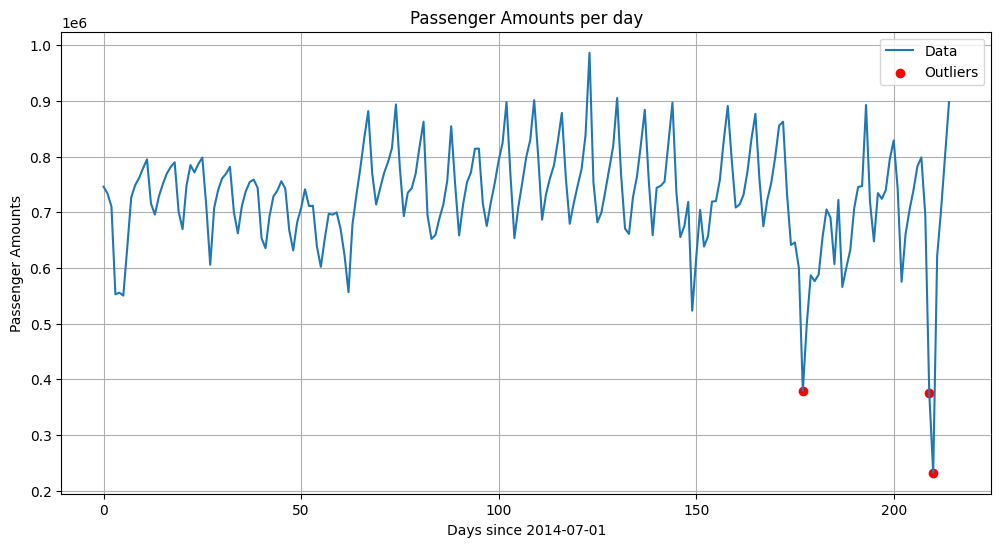

In [8]:
# Calculate the Z-score for each value
grouped_df['zscore'] = (grouped_df['value'] - mean_value) / std_value

print(grouped_df.head())

# Identify outliers based on a Z-score threshold (e.g., |Z-score| > 3)
threshold = 3
outliers = grouped_df[abs(grouped_df['zscore']) > threshold]

print("\nOutliers:")
print(outliers)

#Plot the graph again, highlighting the outliers
plt.figure(figsize=(12, 6))
plt.plot(grouped_df.index, grouped_df['value'], label='Data')
plt.scatter(outliers.index, outliers['value'], color='red', label='Outliers')
plt.xlabel('Days since 2014-07-01')
plt.ylabel('Passenger Amounts')
plt.title('Passenger Amounts per day')
plt.grid(True)
plt.legend()
plt.show()

Now, lets calculate Tukey's Fences.

Lower Bound (Tukey's Fence): 537545.0
Upper Bound (Tukey's Fence): 922357.0

Outliers (Tukey's Fences):
      timestamp   value    zscore
123  2014-11-01  986568  2.795476
149  2014-11-27  523184 -2.187428
177  2014-12-25  379302 -3.734633
178  2014-12-26  499102 -2.446388
209  2015-01-26  375311 -3.777549
210  2015-01-27  232058 -5.317991


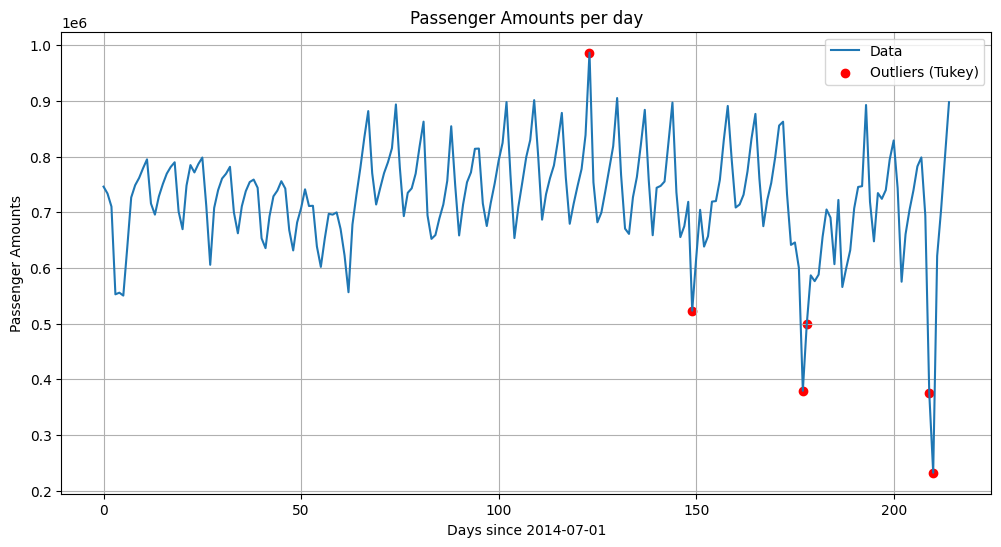

In [9]:
# Calculate quartiles
Q1 = grouped_df['value'].quantile(0.25)
Q3 = grouped_df['value'].quantile(0.75)
IQR = Q3 - Q1

# Calculate Tukey's fences
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower Bound (Tukey's Fence): {lower_bound}")
print(f"Upper Bound (Tukey's Fence): {upper_bound}")

# Identify outliers using Tukey's fences
tukey_outliers = grouped_df[(grouped_df['value'] < lower_bound) | (grouped_df['value'] > upper_bound)]

print("\nOutliers (Tukey's Fences):")
print(tukey_outliers)

# Plot the graph again, highlighting the outliers
plt.figure(figsize=(12, 6))
plt.plot(grouped_df.index, grouped_df['value'], label='Data')
plt.scatter(tukey_outliers.index, tukey_outliers['value'], color='red', label='Outliers (Tukey)')
plt.xlabel('Days since 2014-07-01')
plt.ylabel('Passenger Amounts')
plt.title('Passenger Amounts per day')
plt.grid(True)
plt.legend()
plt.show()

Immediately, we see that Tukey's Fences showcases more outliers and the same that the Z-score outliers identified. I will now investigate the dates and news to find the context as to why passenger rates rose or dropped.

*   2014-11-01  986568  2.795476 - Marathon to take place on Nov. 2, presumably people moving in a day prior to take part, therefore the increase in taxi passengers due to an increase in people.
*   2014-11-27  523184 -2.187428 - Thanksgiving Day Festivities
*   2014-12-25  379302 -3.734633 - Christmas Day Festivities
*   2014-12-26  499102 -2.446388 - Post Christmas Day Festivities
*   2015-01-26  375311 -3.777549 - Winterstorm Juno
*   2015-01-27  232058 -5.317991 - Winterstorm Juno Aftermath

Since there is an event for each day with an abnormal passenger drop or increase, then it seems both methods work perfectly well. A thing to note is that the Z-score metric is much more limited in its anomaly detection as the values it chose are all more extreme cases such as it detecting a Christmas decrease in passengers, but not a Thanksgiving decrease in passengers (assumably from the fact that more people celebrate Christmas than Thanksgiving).

Overall, both methods are accurate, though I would use Tukey's fences to capture more abnormalities, or use the Z-score metric to capture very extreme metrics.